# 1 Layer Neural Network

In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load Model

In [6]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel")

options = Option(
    inputModel = 'KERAS_1layer_weights.h5',
    inputFile = '../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_twolayer.yml',
    jsonModel = 'KERAS_1layer.json'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
yamlConfig

Loading configuration from train_config_twolayer.yml


{'Inputs': ['j_zlogz',
  'j_c1_b0_mmdt',
  'j_c1_b1_mmdt',
  'j_c2_b1_mmdt',
  'j_d2_b1_mmdt',
  'j_d2_a1_b1_mmdt',
  'j_m2_b1_mmdt',
  'j_n2_b1_mmdt',
  'j_mass_mmdt',
  'j_multiplicity'],
 'Labels': ['j_t'],
 'KerasModel': 'two_layer_model',
 'KerasModelRetrain': 'two_layer_model_constraint',
 'KerasLoss': 'binary_crossentropy',
 'L1Reg': 0,
 'NormalizeInputs': 0,
 'InputType': ''}

In [7]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                352       
_________________________________________________________________
output_sigmoid (Dense)       (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


## Load Test Data

In [12]:
def get_features(options, yamlConfig, test_size):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    # To use one data file:
    h5File = h5py.File(options.inputFile, 'r')
    treeArray = h5File[options.tree][()]

    print(treeArray.shape)
    #print(treeArray.dtype.names)
    
    # List of features to use
    features = yamlConfig['Inputs']
    
    # List of labels to use
    labels = yamlConfig['Labels']

    # Convert to dataframe
    features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
    features_labels_df = features_labels_df.drop_duplicates()

    features_df = features_labels_df[features]
    labels_df = features_labels_df[labels]
    
    print(features_df.head())
    print(labels_df.head())
    
    if 'Conv' in yamlConfig['InputType']:
        labels_df = labels_df.drop_duplicates()
        
    # Convert to numpy array 
    features_val = features_df.values
    labels_val = labels_df.values     
    print(labels_val.shape)

    if 'j_index' in features:
        features_val = features_val[:,:-1] # drop the j_index feature
    if 'j_index' in labels:
        labels_val = labels_val[:,:-1] # drop the j_index label
        print(labels_val.shape)

    if yamlConfig['InputType']=='Conv1D':
        features_2dval = np.zeros((len(labels_df), yamlConfig['MaxParticles'], len(features)-1))
        for i in range(0, len(labels_df)):
            features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
            index_values = features_df_i.index.values
            #features_val_i = features_val[index_values[0]:index_values[-1]+1,:-1] # drop the last feature j_index
            features_val_i = features_val[np.array(index_values),:]
            nParticles = len(features_val_i)
            #print("before", features_val_i[:,0])
            features_val_i = features_val_i[features_val_i[:,0].argsort()[::-1]] # sort descending by first value (ptrel, usually)
            #print("after", features_val_i[:,0])
            if nParticles>yamlConfig['MaxParticles']:
                features_val_i =  features_val_i[0:yamlConfig['MaxParticles'],:]
            else:        
                features_val_i = np.concatenate([features_val_i, np.zeros((yamlConfig['MaxParticles']-nParticles, len(features)-1))])
            features_2dval[i, :, :] = features_val_i

        features_val = features_2dval

    elif yamlConfig['InputType']=='Conv2D':
        features_2dval = np.zeros((len(labels_df), yamlConfig['BinsX'], yamlConfig['BinsY'], 1))
        for i in range(0, len(labels_df)):
            features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
            index_values = features_df_i.index.values
            
            xbins = np.linspace(yamlConfig['MinX'],yamlConfig['MaxX'],yamlConfig['BinsX']+1)
            ybins = np.linspace(yamlConfig['MinY'],yamlConfig['MaxY'],yamlConfig['BinsY']+1)

            x = features_df_i[features[0]]           
            y = features_df_i[features[1]]
            w = features_df_i[features[2]]

            hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins,ybins))

            for ix in range(0,yamlConfig['BinsX']):
                for iy in range(0,yamlConfig['BinsY']):
                    features_2dval[i,ix,iy,0] = hist[ix,iy]
        features_val = features_2dval

    X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=test_size, random_state=42)
    
    #Normalize inputs
    if yamlConfig['NormalizeInputs'] and yamlConfig['InputType']!='Conv1D' and yamlConfig['InputType']!='Conv2D':
        scaler = preprocessing.StandardScaler().fit(X_train_val)
        X_train_val = scaler.transform(X_train_val)
        X_test = scaler.transform(X_test)

    #Normalize inputs
    if yamlConfig['NormalizeInputs'] and yamlConfig['InputType']!='Conv1D' and yamlConfig['InputType']!='Conv2D' and yamlConfig['KerasLoss']=='squared_hinge':
        scaler = preprocessing.MinMaxScaler().fit(X_train_val)
        X_train_val = scaler.transform(X_train_val)
        X_test = scaler.transform(X_test)
        y_train_val = y_train_val * 2 - 1
        y_test = y_test * 2 - 1
        
    #Normalize conv inputs
    if yamlConfig['NormalizeInputs'] and yamlConfig['InputType']=='Conv1D':
        reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0]*X_train_val.shape[1],X_train_val.shape[2])
        scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
        for p in range(X_train_val.shape[1]):
            X_train_val[:,p,:] = scaler.transform(X_train_val[:,p,:])
            X_test[:,p,:] = scaler.transform(X_test[:,p,:])    

    if 'j_index' in labels:
        labels = labels[:-1]

    return X_train_val, X_test, y_train_val, y_test, labels

In [13]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.99)

(986806,)
    j_zlogz  j_c1_b0_mmdt  j_c1_b1_mmdt  j_c2_b1_mmdt  j_d2_b1_mmdt  \
0 -2.901162      0.462566      0.039364      0.035541      0.902895   
1 -3.112807      0.460751      0.049826      0.039287      0.788490   
2 -3.363088      0.474168      0.060443      0.094000      1.555191   
3 -2.287620      0.383430      0.008700      0.017118      1.967673   
4 -2.878532      0.453209      0.047442      0.036979      0.779445   

   j_d2_a1_b1_mmdt  j_m2_b1_mmdt  j_n2_b1_mmdt  j_mass_mmdt  j_multiplicity  
0         0.902895      0.069127      0.215783    79.503227            33.0  
1         0.788490      0.066843      0.200235    81.145767            63.0  
2         1.555191      0.126817      0.380907    97.876595            60.0  
3         1.967673      0.109983      0.369561    17.177235            38.0  
4         0.779445      0.066729      0.200641    92.293953            50.0  
   j_t
0    0
1    1
2    1
3    0
4    1
(986806, 1)


In [36]:
X_test.shape

(976938, 10)

In [15]:
y_test.shape

(976938, 1)

## Evaluate

In [23]:
def makeRoc(features_val, labels, labels_val, model, outputDir):
    if 'j_index' in labels: labels.remove('j_index')
    print(features_val)
    predict_test = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    print(df.head())
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'1layerNN ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig('%s/ROC.pdf'%(outputDir))
    return predict_test

[[-3.1480205e+00  4.6019873e-01  1.0369384e-01 ...  2.3688954e-01
   1.6906499e+02  6.2000000e+01]
 [-2.6597891e+00  4.1791797e-01  4.1077029e-02 ...  2.9946610e-01
   8.4231392e+01  4.6000000e+01]
 [-2.7521615e+00  4.3645355e-01  3.9103631e-02 ...  3.1570154e-01
   9.6822571e+01  6.7000000e+01]
 ...
 [-2.1734827e+00  3.7008250e-01  1.6558792e-02 ...  1.9612911e-01
   3.0800652e+01  4.1000000e+01]
 [-3.2259834e+00  4.6611512e-01  1.0163990e-01 ...  3.4031793e-01
   1.8683932e+02  6.9000000e+01]
 [-2.7180085e+00  4.4024944e-01  2.7138812e-02 ...  3.0964842e-01
   6.2693913e+01  4.7000000e+01]]
   j_t  j_t_pred
0    1       0.0
1    0       0.0
2    0       0.0
3    0       0.0
4    0       0.0


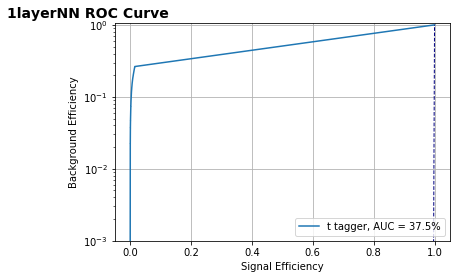

In [24]:
y_pred = makeRoc(X_test, labels, y_test, model, os.curdir)